## Imports


In [53]:
import numpy as np
import os
import SimpleITK as sitk
from matplotlib import pyplot as plt
import cv2
import gui

imagepath = r'LWS\Referenzdaten_Siemens_Proband02_LWS_T2mapping+Volumetry\\'

def list_files(dir_path):
    files = os.listdir(dir_path)
    return [file for file in files if file.startswith("REF02_1.MR.2")]

## Define spinal disc regions with mask image

In [54]:
'''Define joint regions by drawing contours on the image and save the contours as a mask'''
mask_image = cv2.imread('joint_mask.png', 0)

_, thresh = cv2.threshold(mask_image, 250, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

masks = []
for contour in contours:
    mask = np.zeros_like(mask_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)
    masks.append(mask)

# Sort masks by their y position
masks = sorted(masks, key=lambda x: np.min(np.where(x == 255)[0]))

#show masks for debugging
if(False):
    for mask in masks:
        plt.imshow(mask, cmap='gray')
        plt.show()


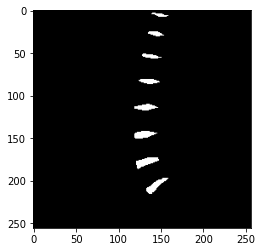

In [55]:
plt.imshow(mask_image, cmap='gray')

### load all images and use the slice location to keep only the center slices, then sort all images by their echotime

In [56]:
files = list_files(imagepath)
images_mr = []

for i, file in enumerate(files[6:]):
    img = sitk.ReadImage(imagepath + file)
    slice_loc = float(img.GetMetaData('0020|1041'))
    # only use center slices
    if (slice_loc < -2 and slice_loc > -3): 
        images_mr.append(img)

px_values = []
echotimes = []
images_np = []
for img in images_mr:
    im = sitk.GetArrayFromImage(img)
    im = np.squeeze(im)
    images_np.append(im)
    # get echo time
    echotimes.append(float(img.GetMetaData('0018|0081')))

# sort images by echo time
echotimes = np.array(echotimes)
sorted_indices = np.argsort(echotimes)
echotimes_sorted = echotimes[sorted_indices]
images_np = np.array(images_np)
images_np_sorted = images_np[sorted_indices]
images_mr_sorted = np.array(images_mr)[sorted_indices]

Progress Disk: 1/8
Progress Disk: 2/8
Progress Disk: 3/8
Progress Disk: 4/8
Progress Disk: 5/8
Progress Disk: 6/8
Progress Disk: 7/8
Progress Disk: 8/8


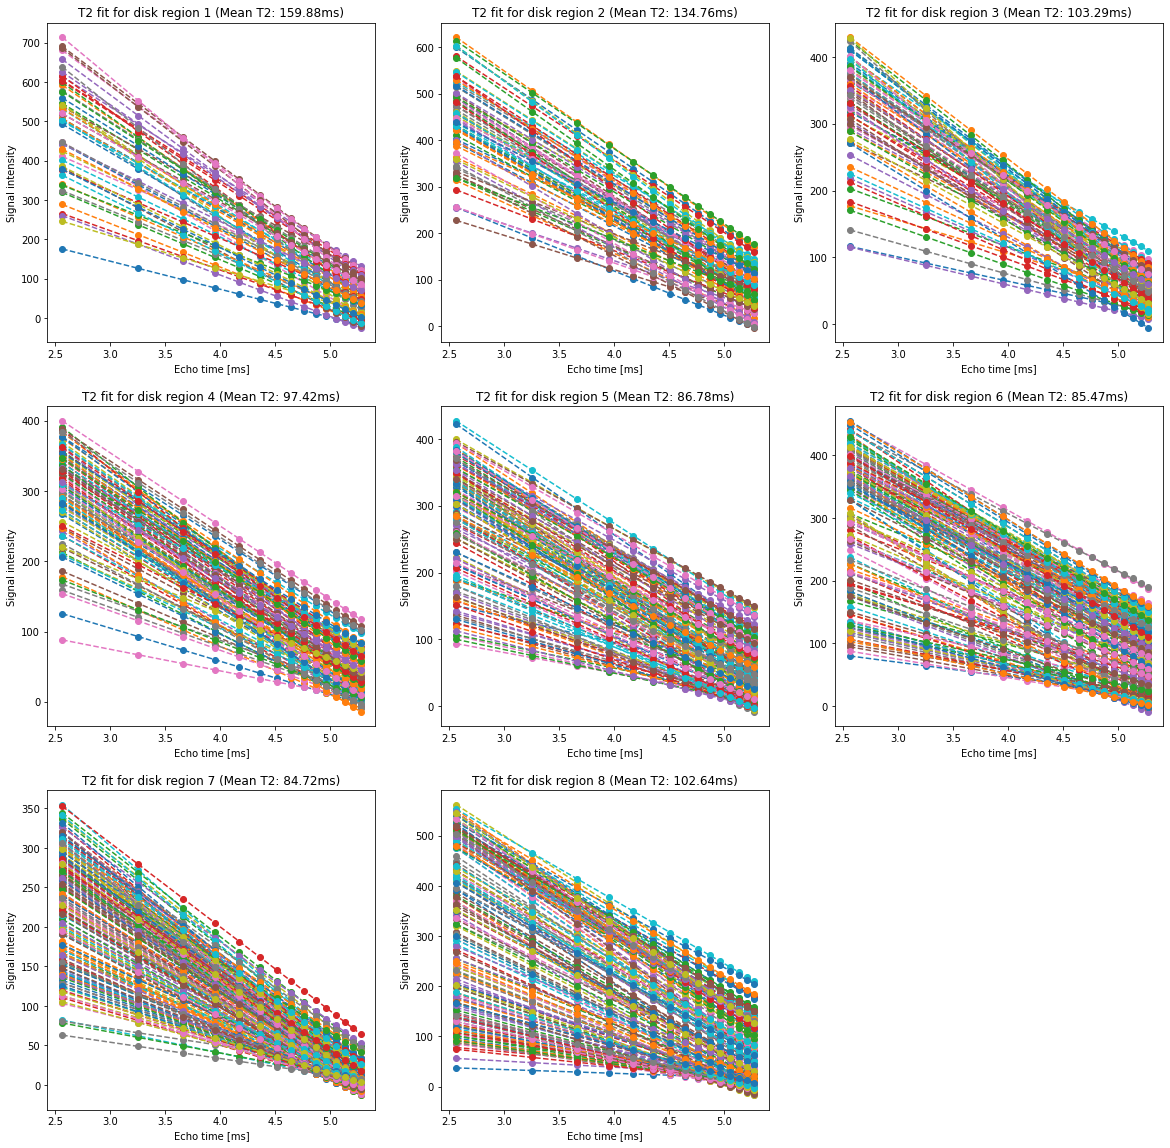

In [60]:
#iterate over all masks and calculate the t2 value for each pixel in the mask and write them into a new img
t2_images = []
t2_means = []
plt.figure(figsize=(20, 20))
ncols = 3 
nrows = (len(masks)+1) // ncols + ((len(masks)+1) % ncols > 0)
for i, mask in enumerate(masks):
    t2_image = np.zeros_like(images_np_sorted[i])
    t2s = []
    #initialize plot with number of subplots equal to the number of masks
    #iterate over each pixel in the mask
    ax = plt.subplot(nrows, ncols, i + 1)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if(mask[x,y] == 255):
                px_values = []
                #iterate over all images and get the pixel values for the mask
                for img in images_np_sorted:
                    px_values.append(img[x,y])
                px_values = np.array(px_values)
                #t2_start = 0.1
                t2 = np.polyfit(-np.log(echotimes_sorted), px_values, 1)
                t2_image[x,y] = t2[0]
                #plot t2 values for each pixel
                px_values_fit = np.polyval(t2, -np.log(echotimes_sorted))
                ax.plot(np.log(echotimes_sorted), px_values_fit, 'o--')
                t2s.append(t2[0])   
    title = 'T2 fit for disk region ' + str(i+1) + ' (Mean T2: ' + "{:.2f}".format(np.mean(t2s)) + 'ms)'
    ax.set_title(title)
    ax.set_xlabel('Echo time [ms]')
    ax.set_ylabel('Signal intensity')

    t2_images.append(t2_image)
    t2_means.append(np.mean(t2s))
    #print progress
    print('Progress Disk: ' + str(i+1) + '/' + str(len(masks)))
    
#show all plots
plt.show()
    


### create t2 mapping

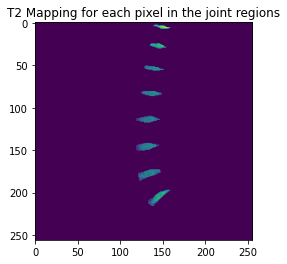

In [58]:

#combine all t2 images into one image
t2_image = np.zeros_like(t2_images[0])
for img in t2_images:
    t2_image += img

#image_t2 = image_t2 + t2_image
plt.imshow(t2_image)
plt.title('T2 Mapping for each pixel in the joint regions')
plt.show()